**Objective:** Transform and standardise audio features from the cleaned Spotify tracks dataset to prepare for similarity-based song recommendations.

**Input:** `../data/processed/spotify_tracks.csv` (cleaned dataset)  
**Process:** Load → Explore → Standardise Audio Features → Validate → Export  
**Output:** `../data/processed/spotify_tracks_features_engineered.csv`

#### 1. Setting up the Environment
For this feature engineering process, we'll utilise:
- **pandas**: for data loading and manipulation  
- **numpy**: for numerical operations  
- **scikit-learn**: for StandardScaler preprocessing
- **matplotlib & seaborn**: for data visualisation
- **pathlib.Path**: for handling file paths in a platform-independent way

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# Machine learning preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print("Libraries imported successfully!")

Libraries imported successfully!


#### 2. Load Cleaned Data
Load the cleaned Spotify dataset that was processed in our ETL pipeline. This will serve as input for our feature engineering process.

In [3]:
# Define file paths
INPUT_CSV = Path("../data/processed/spotify_tracks.csv")
OUTPUT_CSV = Path("../data/processed/spotify_tracks_features_engineered.csv")

print(f"Input file: {INPUT_CSV.resolve()}")
print(f"Output file: {OUTPUT_CSV.resolve()}")

# Load cleaned dataset
try:
    df = pd.read_csv(INPUT_CSV)
    print(f"\nDataset loaded successfully!")
    print(f"Shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: Could not find {INPUT_CSV}")
except Exception as e:
    print(f"Error loading data: {e}")

Input file: /Users/julianelliott/Documents/GitHub/song-recommendation-dashboard/data/processed/spotify_tracks.csv
Output file: /Users/julianelliott/Documents/GitHub/song-recommendation-dashboard/data/processed/spotify_tracks_features_engineered.csv

Dataset loaded successfully!
Shape: (113999, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


#### 3. Explore Dataset Structure
Before engineering features, let's understand our data structure and identify the audio features that require standardisation for euclidean distance calculations.

In [4]:
# Display basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check for any remaining missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
Shape: (113999, 20)
Columns: ['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Data Types:
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

Missing Values:
track_id            0
artists             0
album_name          0
track_name          0
pop

#### 4. Identify Audio Features for Standardisation
Define the audio features that will be standardised. These features have different scales and units, so standardisation is crucial for accurate euclidean distance measurements in our recommendation system.

In [5]:
# Define audio features to be standardised
audio_features = [
    'danceability',    # 0.0 to 1.0
    'energy',          # 0.0 to 1.0
    'key',             # -1 to 11 (pitch class)
    'loudness',        # typically -60 to 0 dB
    'mode',            # 0 or 1 (minor/major)
    'speechiness',     # 0.0 to 1.0
    'acousticness',    # 0.0 to 1.0
    'instrumentalness', # 0.0 to 1.0
    'liveness',        # 0.0 to 1.0
    'valence',         # 0.0 to 1.0
    'tempo',           # typically 50 to 200+ BPM
    'time_signature'   # 3 to 7
]

print(f"Audio features to standardise: {len(audio_features)}")
print(audio_features)

# Verify all features exist in dataset
missing_features = [f for f in audio_features if f not in df.columns]
if missing_features:
    print(f"\nWarning: Missing features: {missing_features}")
else:
    print("\nAll audio features found in dataset ✓")

Audio features to standardise: 12
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

All audio features found in dataset ✓


#### 5. Analyse Feature Distributions
Examine the distributions and scales of our audio features before standardisation to understand why scaling is necessary.

Audio Features - Descriptive Statistics:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,0.566801,0.641383,5.309126,-8.258950,0.637558,0.084652,0.314907,0.156051,0.213554,0.474066,122.147695,3.904034
std,0.173543,0.251530,3.559999,5.029357,0.480708,0.105733,0.332522,0.309556,0.190378,0.259261,29.978290,0.432623
min,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218500,4.000000
50%,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.597500,0.049000,0.273000,0.683000,140.071000,4.000000
max,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


Feature distribution plot saved to: /Users/julianelliott/Documents/GitHub/song-recommendation-dashboard/results/audio_features_distribution.png


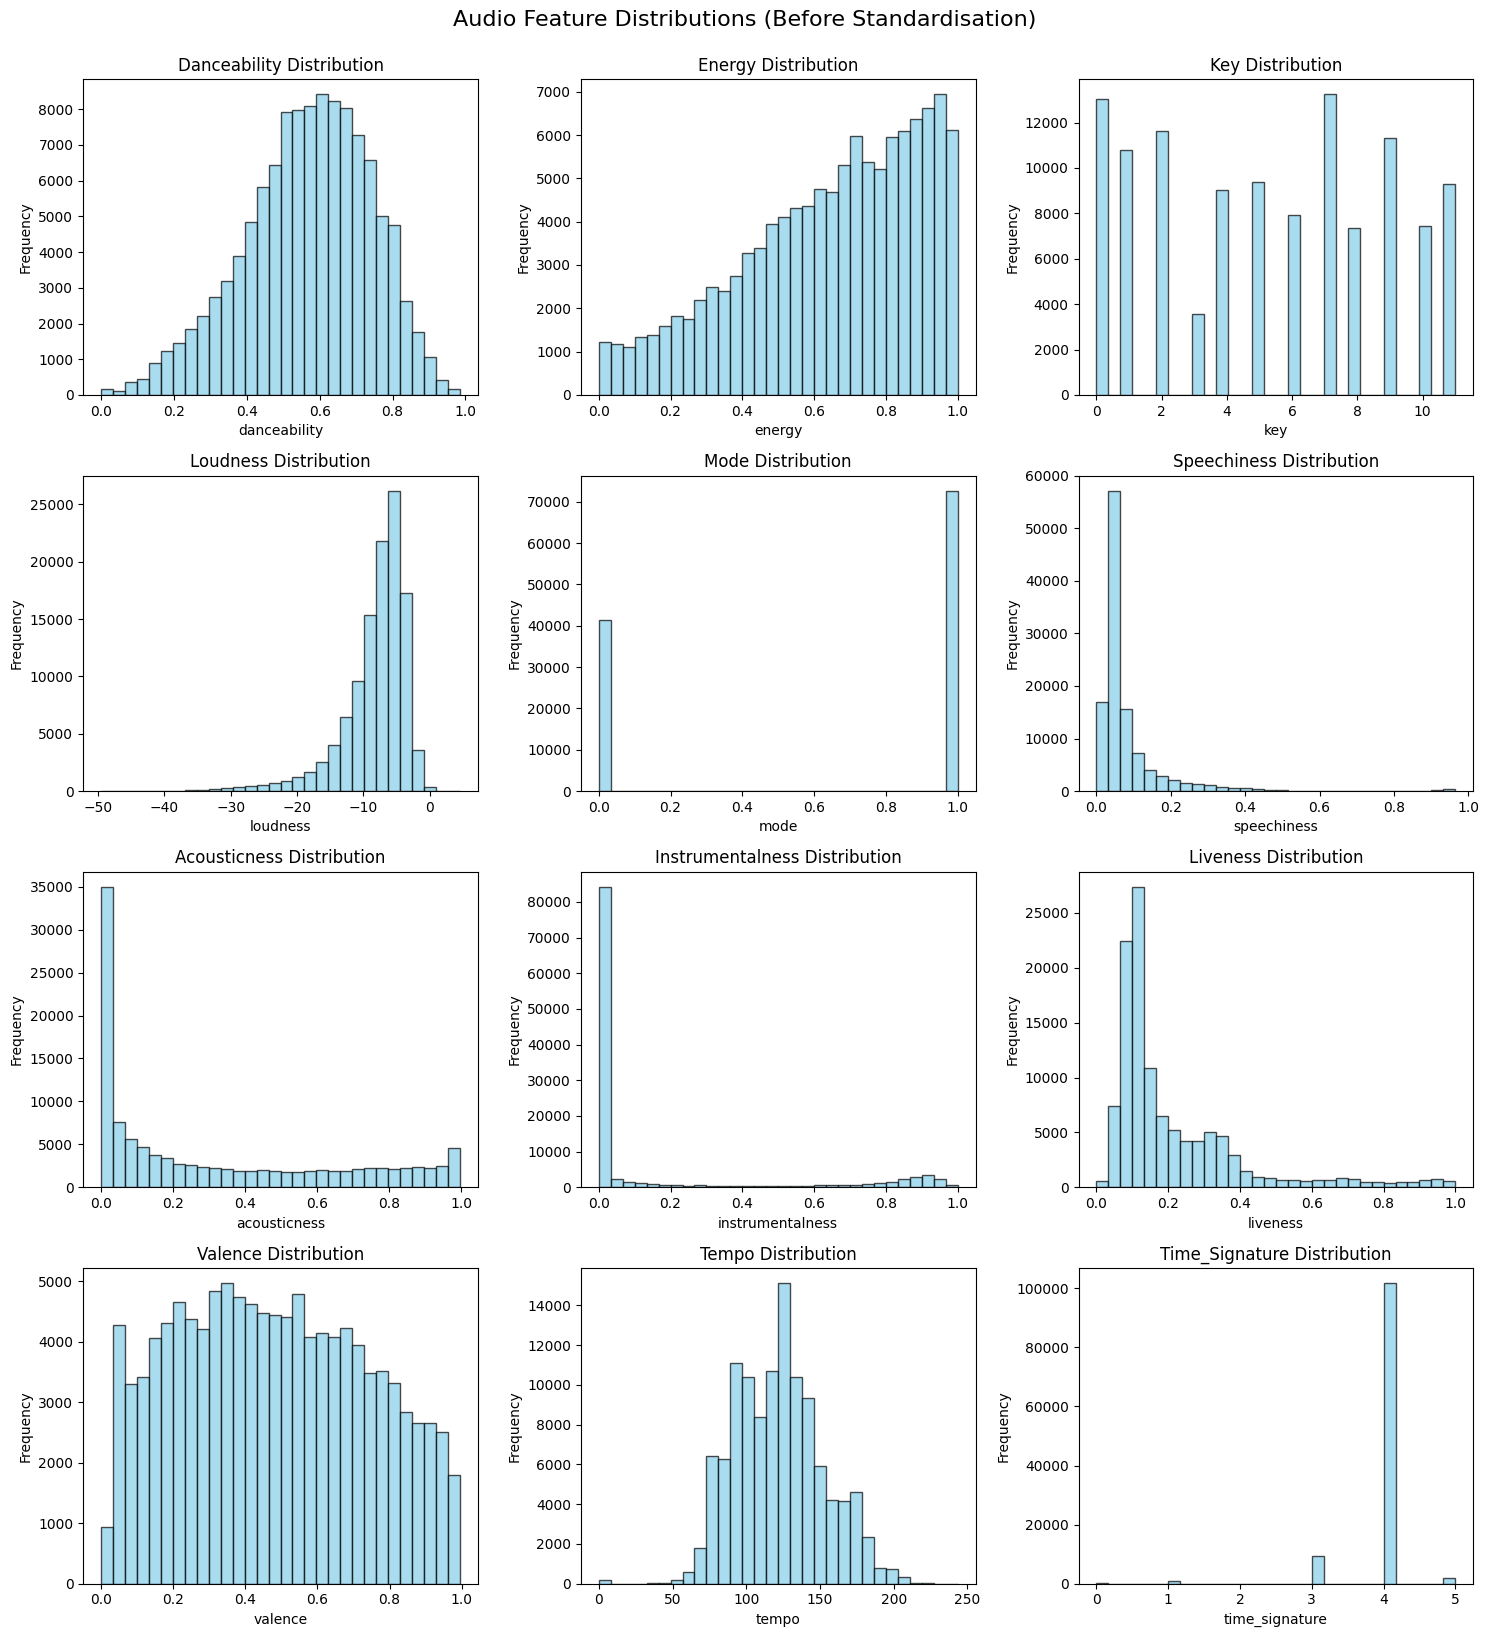

In [6]:
# Display descriptive statistics for audio features
print("Audio Features - Descriptive Statistics:")
audio_stats = df[audio_features].describe()
display(audio_stats)

# Create visualisations of feature distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
axes = axes.ravel()

for i, feature in enumerate(audio_features):
    axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature.title()} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Audio Feature Distributions (Before Standardisation)', y=1.02, fontsize=16)

# Save the plot as PNG file
results_path = Path("../results/audio_features_distribution.png")
plt.savefig(results_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Feature distribution plot saved to: {results_path.resolve()}")

plt.show()

#### 6. Standardise Audio Features
Apply StandardScaler to normalise all audio features to have mean=0 and standard deviation=1. This ensures all features contribute equally to euclidean distance calculations.

In [7]:
# Create a copy of the dataset for feature engineering
df_engineered = df.copy()

# Initialise StandardScaler
scaler = StandardScaler()

# Extract audio features for scaling
audio_data = df_engineered[audio_features]

# Fit and transform the audio features
audio_scaled = scaler.fit_transform(audio_data)

# Create column names for scaled features
scaled_feature_names = [f'{feature}_scaled' for feature in audio_features]

# Create DataFrame with scaled features
audio_scaled_df = pd.DataFrame(audio_scaled, columns=scaled_feature_names, index=df_engineered.index)

# Add scaled features to the main dataframe
df_engineered = pd.concat([df_engineered, audio_scaled_df], axis=1)

print("Audio features successfully standardised!")
print(f"Added {len(scaled_feature_names)} scaled features:")
print(scaled_feature_names)

Audio features successfully standardised!
Added 12 scaled features:
['danceability_scaled', 'energy_scaled', 'key_scaled', 'loudness_scaled', 'mode_scaled', 'speechiness_scaled', 'acousticness_scaled', 'instrumentalness_scaled', 'liveness_scaled', 'valence_scaled', 'tempo_scaled', 'time_signature_scaled']


#### 7. Validate Standardisation
Verify that our standardised features have the expected properties (mean ≈ 0, std ≈ 1) and compare with original distributions.

Standardised Features - Descriptive Statistics:


,danceability_scaled,energy_scaled,key_scaled,loudness_scaled,mode_scaled,speechiness_scaled,acousticness_scaled,instrumentalness_scaled,liveness_scaled,valence_scaled,tempo_scaled,time_signature_scaled
count,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05,1.139990e+05
mean,-9.972617e-17,1.954633e-16,1.844934e-17,-1.555728e-16,-7.579189e-17,1.595619e-17,-7.978094e-18,-2.393428e-17,5.385213e-17,-1.595619e-17,4.567459e-16,-1.994523e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-3.266071e+00,-2.549938e+00,-1.491334e+00,-8.206263e+00,-1.326297e+00,-8.006285e-01,-9.470287e-01,-5.041145e-01,-1.121741e+00,-1.828535e+00,-4.074556e+00,-9.024149e+00
25%,-6.384656e-01,-6.734145e-01,-9.295339e-01,-3.487638e-01,-1.326297e+00,-4.610919e-01,-8.962048e-01,-5.041145e-01,-6.069741e-01,-8.256808e-01,-7.648634e-01,2.218242e-01
50%,7.605855e-02,1.734064e-01,-8.683341e-02,2.495260e-01,7.539789e-01,-3.381399e-01,-4.387898e-01,-5.039801e-01,-4.283813e-01,-3.882571e-02,-4.359668e-03,2.218242e-01
75%,7.387221e-01,8.452970e-01,7.558671e-01,6.473917e-01,7.539789e-01,-1.440658e-03,8.498512e-01,-3.458225e-01,3.122534e-01,8.058864e-01,5.978788e-01,2.218242e-01
max,2.409787e+00,1.425747e+00,1.598568e+00,2.543268e+00,7.539789e-01,8.326191e+00,2.048272e+00,2.726334e+00,4.130987e+00,2.009312e+00,4.043754e+00,2.533318e+00



Standardisation Validation:
danceability_scaled: Mean = -0.000000, Std = 1.000004
energy_scaled: Mean = 0.000000, Std = 1.000004
key_scaled: Mean = 0.000000, Std = 1.000004
loudness_scaled: Mean = -0.000000, Std = 1.000004
mode_scaled: Mean = -0.000000, Std = 1.000004
speechiness_scaled: Mean = 0.000000, Std = 1.000004
acousticness_scaled: Mean = -0.000000, Std = 1.000004
instrumentalness_scaled: Mean = -0.000000, Std = 1.000004
liveness_scaled: Mean = 0.000000, Std = 1.000004
valence_scaled: Mean = -0.000000, Std = 1.000004
tempo_scaled: Mean = 0.000000, Std = 1.000004
time_signature_scaled: Mean = -0.000000, Std = 1.000004
Standardisation comparison plot saved to: /Users/julianelliott/Documents/GitHub/song-recommendation-dashboard/results/standardisation_comparison.png


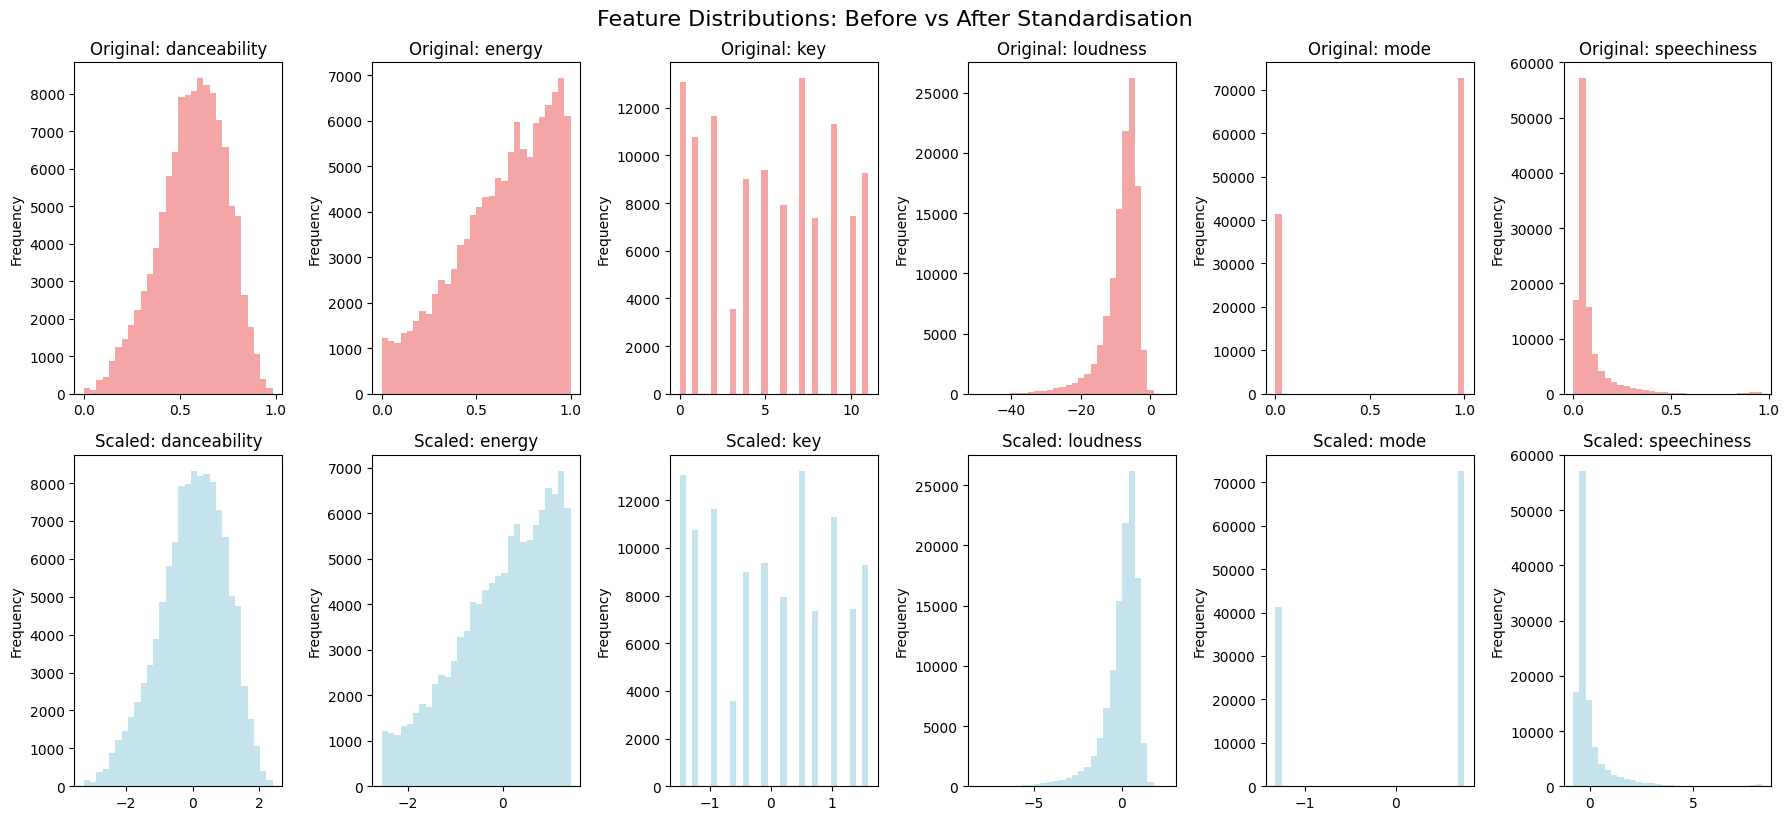

In [8]:
# Check standardisation results
print("Standardised Features - Descriptive Statistics:")
scaled_stats = df_engineered[scaled_feature_names].describe()
display(scaled_stats)

# Verify mean and standard deviation
print("\nStandardisation Validation:")
for feature in scaled_feature_names:
    mean_val = df_engineered[feature].mean()
    std_val = df_engineered[feature].std()
    print(f"{feature}: Mean = {mean_val:.6f}, Std = {std_val:.6f}")

# Visualise before/after standardisation
fig, axes = plt.subplots(2, 6, figsize=(18, 8))

for i, feature in enumerate(audio_features[:6]):  # Show first 6 features
    # Original distribution
    axes[0, i].hist(df[feature].dropna(), bins=30, alpha=0.7, color='lightcoral')
    axes[0, i].set_title(f'Original: {feature}')
    axes[0, i].set_ylabel('Frequency')
    
    # Scaled distribution
    scaled_feature = f'{feature}_scaled'
    axes[1, i].hist(df_engineered[scaled_feature].dropna(), bins=30, alpha=0.7, color='lightblue')
    axes[1, i].set_title(f'Scaled: {feature}')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Feature Distributions: Before vs After Standardisation', y=1.02, fontsize=16)

# Save the comparison plot as PNG file
comparison_path = Path("../results/standardisation_comparison.png")
plt.savefig(comparison_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Standardisation comparison plot saved to: {comparison_path.resolve()}")

plt.show()

#### 8. Create Feature Matrix for Similarity Calculations
Extract the standardised audio features into a clean matrix that can be used for euclidean distance calculations in our recommendation system.

In [9]:
# Create feature matrix with only scaled audio features
feature_matrix = df_engineered[scaled_feature_names].values

print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Feature matrix type: {type(feature_matrix)}")

# Display sample of feature matrix
print("\nSample of standardised feature matrix:")
feature_matrix_df = pd.DataFrame(feature_matrix[:5], columns=scaled_feature_names)
display(feature_matrix_df)

# Test euclidean distance calculation on sample
print("\nTesting euclidean distance calculation:")
# Calculate distance between first two tracks
sample_distances = euclidean_distances(feature_matrix[:2])
print(f"Distance between first two tracks: {sample_distances[0,1]:.4f}")

Feature matrix shape: (113999, 12)
Feature matrix type: <class 'numpy.ndarray'>

Sample of standardised feature matrix:


,danceability_scaled,energy_scaled,key_scaled,loudness_scaled,mode_scaled,speechiness_scaled,acousticness_scaled,instrumentalness_scaled,liveness_scaled,valence_scaled,tempo_scaled,time_signature_scaled
0,0.629239,-0.717147,-1.210434,0.300825,-1.326297,0.551843,-0.850193,-0.504111,0.758735,0.929315,-1.141854,0.221824
1,-0.845908,-1.889974,-1.210434,-1.784739,0.753979,-0.078995,1.831744,-0.504097,-0.591216,-0.798681,-1.489708,0.221824
2,-0.742187,-1.122667,-1.491334,-0.293289,0.753979,-0.273827,-0.315489,-0.504115,-0.507172,-1.365679,-1.528303,0.221824
3,-1.733301,-2.312987,-1.491334,-2.039246,0.753979,-0.457309,1.774605,-0.503886,-0.428381,-1.276965,1.987857,-2.089669
4,0.295026,-0.788709,-0.929534,-0.282751,0.753979,-0.303146,0.463409,-0.504115,-0.686290,-1.184394,-0.073343,0.221824



Testing euclidean distance calculation:
Distance between first two tracks: 4.9748


#### 9. Add Additional Engineered Features
Create some additional useful features for the recommendation system.

In [10]:
# Create additional engineered features
print("Creating additional engineered features...")

# Duration in minutes (more interpretable)
df_engineered['duration_min'] = df_engineered['duration_ms'] / 60000

# Popularity categories
df_engineered['popularity_category'] = pd.cut(
    df_engineered['popularity'], 
    bins=[0, 25, 50, 75, 100], 
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Energy-Valence combination (mood indicator)
df_engineered['mood_score'] = (df_engineered['energy'] + df_engineered['valence']) / 2

# Danceability-Energy combination (party potential)
df_engineered['party_score'] = (df_engineered['danceability'] + df_engineered['energy']) / 2

print("Additional features created:")
print("- duration_min: Track duration in minutes")
print("- popularity_category: Categorical popularity levels")
print("- mood_score: Combined energy and valence (0-1)")
print("- party_score: Combined danceability and energy (0-1)")

# Display sample of new features
new_features = ['duration_min', 'popularity_category', 'mood_score', 'party_score']
display(df_engineered[new_features].head())

Creating additional engineered features...
Additional features created:
- duration_min: Track duration in minutes
- popularity_category: Categorical popularity levels
- mood_score: Combined energy and valence (0-1)
- party_score: Combined danceability and energy (0-1)


,duration_min,popularity_category,mood_score,party_score
0,3.844433,High,0.5880,0.5685
1,2.493500,High,0.2165,0.2930
2,3.513767,High,0.2395,0.3985
3,3.365550,High,0.1013,0.1628
4,3.314217,Very High,0.3050,0.5305


#### 10. Export Engineered Dataset
Save the feature-engineered dataset with both original and standardised features for use in the recommendation system.

In [11]:
# Export the feature-engineered dataset
df_engineered.to_csv(OUTPUT_CSV, index=False)

print(f"Feature-engineered dataset exported successfully!")
print(f"Output location: {OUTPUT_CSV.resolve()}")
print(f"Final dataset shape: {df_engineered.shape}")

# Display final column summary
print(f"\nFinal dataset contains {len(df_engineered.columns)} columns:")
print("Original columns:", len(df.columns))
print("Scaled audio features:", len(scaled_feature_names))
print("Additional engineered features:", len(new_features))

Feature-engineered dataset exported successfully!
Output location: /Users/julianelliott/Documents/GitHub/song-recommendation-dashboard/data/processed/spotify_tracks_features_engineered.csv
Final dataset shape: (113999, 36)

Final dataset contains 36 columns:
Original columns: 20
Scaled audio features: 12
Additional engineered features: 4


## 11. Summary & Next Steps

#### Feature Engineering Summary

- **Data Loading:** Successfully loaded cleaned Spotify dataset with 114,000+ tracks
- **Feature Identification:** Identified 12 audio features requiring standardisation
- **Standardisation:** Applied StandardScaler to normalise all audio features (mean=0, std=1)
- **Validation:** Verified standardisation results and visualised distributions
- **Feature Matrix:** Created clean feature matrix for euclidean distance calculations
- **Additional Features:** Engineered 4 additional features for enhanced recommendations

#### Output Features

**Standardised Audio Features (for similarity calculations):**
- `danceability_scaled`, `energy_scaled`, `key_scaled`, `loudness_scaled`
- `mode_scaled`, `speechiness_scaled`, `acousticness_scaled`, `instrumentalness_scaled`
- `liveness_scaled`, `valence_scaled`, `tempo_scaled`, `time_signature_scaled`

**Additional Engineered Features:**
- `duration_min`: Track duration in minutes
- `popularity_category`: Categorical popularity levels  
- `mood_score`: Energy + valence combination
- `party_score`: Danceability + energy combination

## Next Steps
- Build similarity calculation functions using standardised features
- Implement k-nearest neighbours for song recommendations
- Create recommendation API endpoints
- Develop interactive dashboard for music recommendations